In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


from typing import List, Optional, Tuple

In [2]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'
IMAGE_SIZE = 96
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

COARSE_EMOTIONS = ['happy', 'fear', 'angry', 'other']
FINE_EMOTIONS   = ['neutral', 'disgust', 'sad', 'surprise']


coarse_map = {}
for e in EMOTIONS:
    if e in COARSE_EMOTIONS[:-1]:
        coarse_map[e] = COARSE_EMOTIONS.index(e)
    else:
        coarse_map[e] = COARSE_EMOTIONS.index('other')

fine_map = { e:i for i,e in enumerate(FINE_EMOTIONS) }

def get_coarse_label_idx(label_name: str) -> int:
    return coarse_map[label_name]

def get_fine_label_idx(label_name: str) -> int:
    return fine_map[label_name]



cuda


In [3]:
class EmotionDataset(Dataset):
	"""
	Custom PyTorch Dataset for loading facial emotion images.

	Each sample consists of:
	- A grayscale image loaded from a file path.
	- An associated emotion label.

	Args:
		image_paths (List[str]): List of file paths to the images.
		labels (List[int]): List of corresponding emotion labels.
		transform (Optional[callable], optional): Optional transformation to be applied on an image.
	"""

	def __init__(self, image_paths: List[str], labels: List[int], transform: Optional[callable] = None) -> None:
		self.image_paths = image_paths
		self.labels = labels
		self.transform = transform

	def __len__(self) -> int:
		"""
		Returns the total number of samples in the dataset.

		Returns:
			int: Number of samples.
		"""
		return len(self.image_paths)

	def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
		"""
		Retrieves the image and label at the specified index.

		Args:
			idx (int): Index of the sample to retrieve.

		Returns:
			Tuple[torch.Tensor, int]: A tuple containing the image tensor and its label.
		"""
		# Load image in grayscale mode
		img_path: str = self.image_paths[idx]
		image: Image.Image = Image.open(img_path).convert('L')

		# Apply transformations if provided
		if self.transform:
			image = self.transform(image)

		label: int = self.labels[idx]

		return image, label

In [4]:

def create_dataframe(dir: str) -> Tuple[List[str], List[str]]:
	"""
	Scans a directory structure and creates lists of image file paths and their corresponding labels.

	Expected directory structure:
		dir/
			|-- label_1/
			|     |-- img1.jpg
			|     |-- img2.jpg
			|-- label_2/
			|     |-- img3.jpg
			|     |-- img4.jpg

	Args:
		dir (str): Path to the root directory containing subdirectories for each label.

	Returns:
		Tuple[List[str], List[str]]: 
			- List of full image paths.
			- List of corresponding labels (as strings).
	"""
	image_paths: List[str] = []
	labels: List[str] = []

	
	for label in os.listdir(dir):
		label_dir: str = os.path.join(dir, label)
		if os.path.isdir(label_dir):  
			for image_name in os.listdir(label_dir):
				# Add full image path and corresponding label
				image_paths.append(os.path.join(label_dir, image_name))
				labels.append(label)
			print(f"{label} completed")

	return image_paths, labels

In [5]:
def get_label_idx(label_name: str) -> int:
	"""
	Returns the index of a given emotion label based on the EMOTIONS list.

	Args:
		label_name (str): Name of the emotion (e.g., 'happy', 'sad').

	Returns:
		int: Corresponding index of the emotion in the EMOTIONS list.
	"""
	return EMOTIONS.index(label_name)

In [6]:
from torchvision.transforms import RandomErasing

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    RandomErasing(p=0.5, scale=(0.02, 0.2))
])

In [7]:
from collections import Counter
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler

def create_datasets() -> Tuple[
    DataLoader,  # dl_train_coarse
    DataLoader,  # dl_test_coarse
    DataLoader,  # dl_train_fine
    DataLoader   # dl_test_fine
]:
    """
    Construiește DataLoader-ele pentru:
      - clasificarea grosieră (coarse: 4 clase)
      - clasificarea fină  (fine: 4 clase din 'other')

    Folosește WeightedRandomSampler pentru oversampling pe seturile de antrenament.
    """

    train_paths, train_names = create_dataframe(TRAIN_DIR)
    test_paths,  test_names  = create_dataframe(TEST_DIR)

    
    train_coarse = [get_coarse_label_idx(n) for n in train_names]
    test_coarse  = [get_coarse_label_idx(n) for n in test_names]


    ds_train_coarse = EmotionDataset(train_paths, train_coarse, transform)
    ds_test_coarse  = EmotionDataset(test_paths,  test_coarse,  transform)

    
    counts_c      = Counter(train_coarse)
    freqs_c       = np.array([counts_c[i] for i in range(len(COARSE_EMOTIONS))], dtype=float)
    weights_c     = 1.0 / freqs_c
    sample_weights_c = [weights_c[label] for label in train_coarse]
    sampler_c     = WeightedRandomSampler(sample_weights_c, num_samples=len(sample_weights_c), replacement=True)

    dl_train_coarse = DataLoader(
        ds_train_coarse,
        batch_size=BATCH_SIZE,
        sampler=sampler_c
    )
    dl_test_coarse = DataLoader(
        ds_test_coarse,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    
    fine_pairs_train = [
        (p, n) for p, n in zip(train_paths, train_names)
        if n in FINE_EMOTIONS
    ]
    fine_pairs_test = [
        (p, n) for p, n in zip(test_paths, test_names)
        if n in FINE_EMOTIONS
    ]
    train_paths_f, train_names_f = zip(*fine_pairs_train)
    test_paths_f,  test_names_f  = zip(*fine_pairs_test)

    train_fine = [get_fine_label_idx(n) for n in train_names_f]
    test_fine  = [get_fine_label_idx(n) for n in test_names_f]

    ds_train_fine = EmotionDataset(list(train_paths_f), list(train_fine), transform)
    ds_test_fine  = EmotionDataset(list(test_paths_f),  list(test_fine),  transform)

    
    counts_f        = Counter(train_fine)
    freqs_f         = np.array([counts_f[i] for i in range(len(FINE_EMOTIONS))], dtype=float)
    weights_f       = 1.0 / freqs_f
    sample_weights_f = [weights_f[label] for label in train_fine]
    sampler_f       = WeightedRandomSampler(sample_weights_f, num_samples=len(sample_weights_f), replacement=True)

    dl_train_fine = DataLoader(
        ds_train_fine,
        batch_size=BATCH_SIZE,
        sampler=sampler_f
    )
    dl_test_fine = DataLoader(
        ds_test_fine,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return dl_train_coarse, dl_test_coarse, dl_train_fine, dl_test_fine

In [8]:
class EmotionCNN(nn.Module):
	"""
	A Convolutional Neural Network (CNN) for emotion classification from grayscale facial images.

	Architecture Overview:
	- 3 convolutional blocks (Conv2D + ReLU + MaxPooling + Dropout)
	- Fully connected layers for feature integration and final classification.

	Args:
		num_classes (int): Number of output classes (default: 7).
	"""

	def __init__(self, num_classes: int = 7) -> None:
		super(EmotionCNN, self).__init__()

		# First convolutional block
		self.conv1: nn.Conv2d = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
		self.pool1: nn.MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
		self.dropout1: nn.Dropout = nn.Dropout(0.2)

		# Second convolutional block
		self.conv2: nn.Conv2d = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
		self.pool2: nn.MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
		self.dropout2: nn.Dropout = nn.Dropout(0.2)

		# Third convolutional block
		self.conv3: nn.Conv2d = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
		self.pool3: nn.MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
		self.dropout3: nn.Dropout = nn.Dropout(0.2)

		# Calculate flattened feature size
		# After 3 pooling layers (stride=2), input size reduces by a factor of 8
		self.flat_features: int = 512 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8)

		# Fully connected layers
		self.fc1: nn.Linear = nn.Linear(self.flat_features, 512)
		self.dropout4: nn.Dropout = nn.Dropout(0.2)
		self.fc2: nn.Linear = nn.Linear(512, 256)
		self.dropout5: nn.Dropout = nn.Dropout(0.2)
		self.fc3: nn.Linear = nn.Linear(256, num_classes)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		"""
		Defines the forward pass of the network.

		Args:
			x (torch.Tensor): Input tensor of shape (batch_size, 1, 96, 96).

		Returns:
			torch.Tensor: Output tensor of shape (batch_size, num_classes).
		"""
		# First convolutional block
		x = F.relu(self.conv1(x))
		x = self.pool1(x)
		x = self.dropout1(x)

		# Second convolutional block
		x = F.relu(self.conv2(x))
		x = self.pool2(x)
		x = self.dropout2(x)

		# Third convolutional block
		x = F.relu(self.conv3(x))
		x = self.pool3(x)
		x = self.dropout3(x)

		# Flatten the tensor
		x = x.view(-1, self.flat_features)

		# Fully connected layers
		x = F.relu(self.fc1(x))
		x = self.dropout4(x)
		x = F.relu(self.fc2(x))
		x = self.dropout5(x)
		x = self.fc3(x)  

		return x

In [9]:
def train_model(
	model: nn.Module,
	train_loader: DataLoader,
	test_loader: DataLoader,
	criterion: nn.Module,
	optimizer: torch.optim.Optimizer,
	num_epochs: int
) -> None:
	"""
	Trains and validates the model over a specified number of epochs.

	Args:
		model (nn.Module): The neural network model to be trained.
		train_loader (DataLoader): DataLoader for the training dataset.
		test_loader (DataLoader): DataLoader for the validation/testing dataset.
		criterion (nn.Module): Loss function to optimize.
		optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
		num_epochs (int): Number of epochs to train the model.

	Returns:
		None
	"""
	best_accuracy: float = 0.0

	for epoch in range(num_epochs):
		# Training phase
		model.train()
		running_loss: float = 0.0
		correct: int = 0
		total: int = 0

		for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
			inputs = inputs.to(DEVICE)
			labels = labels.to(DEVICE)

			
			optimizer.zero_grad()

			
			outputs = model(inputs)
			loss = criterion(outputs, labels)

			
			loss.backward()
			optimizer.step()

			# Update training statistics
			running_loss += loss.item() * inputs.size(0)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()

		epoch_loss: float = running_loss / len(train_loader.dataset)
		epoch_acc: float = correct / total

		# Validation phase
		model.eval()
		val_loss: float = 0.0
		val_correct: int = 0
		val_total: int = 0

		with torch.no_grad():
			for inputs, labels in tqdm(test_loader, desc='Validation'):
				inputs = inputs.to(DEVICE)
				labels = labels.to(DEVICE)

				outputs = model(inputs)
				loss = criterion(outputs, labels)

				val_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				val_total += labels.size(0)
				val_correct += (predicted == labels).sum().item()

		val_loss = val_loss / len(test_loader.dataset)
		val_acc = val_correct / val_total

		
		print(f'Epoch {epoch + 1}/{num_epochs}:')
		print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
		print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

		
		if val_acc > best_accuracy:
			best_accuracy = val_acc
			torch.save(model.state_dict(), 'emotion_model.pth')
			print(f'Model saved with accuracy: {best_accuracy:.4f}')

	print(f'Best validation accuracy: {best_accuracy:.4f}')

In [10]:
def predict_emotion(model: nn.Module, image_path: str) -> str:
	"""
	Predicts the emotion label for a given input image.

	Args:
		model (nn.Module): Trained emotion classification model.
		image_path (str): Path to the input image file.

	Returns:
		str: Predicted emotion label.
	"""
	model.eval()

	
	image: Image.Image = Image.open(image_path).convert('L')  # Convert to grayscale
	image = transform(image).unsqueeze(0).to(DEVICE)  # Apply transformations and add batch dimension

	# Perform prediction
	with torch.no_grad():
		outputs: torch.Tensor = model(image)
		_, predicted = torch.max(outputs, dim=1)

	return EMOTIONS[predicted.item()]



def predict_hierarchical(image_path: str,model_coarse,model_fine) -> str:
    img = Image.open(image_path).convert('L')
    x   = transform(img).unsqueeze(0).to(DEVICE)

    model_coarse.eval()
    with torch.no_grad():
        out_c = model_coarse(x)
        pred_c = torch.argmax(out_c, dim=1).item()
        label_c = COARSE_EMOTIONS[pred_c]

    if label_c != 'other':
        return label_c

    model_fine.eval()
    with torch.no_grad():
        out_f = model_fine(x)
        pred_f = torch.argmax(out_f, dim=1).item()
        return FINE_EMOTIONS[pred_f]


angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed
angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


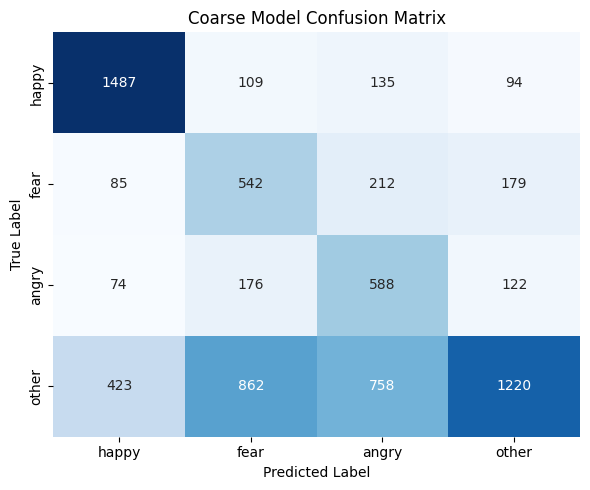

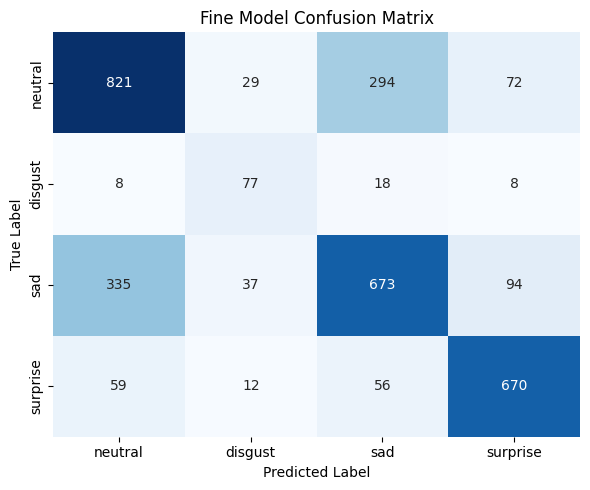

In [11]:


dl_tr_c, dl_te_c, dl_tr_f, dl_te_f = create_datasets()

model_coarse = EmotionCNN(num_classes=len(COARSE_EMOTIONS)).to(DEVICE)
model_fine   = EmotionCNN(num_classes=len(FINE_EMOTIONS)).to(DEVICE)
model_coarse.load_state_dict(torch.load('coarse_model.pth', map_location=DEVICE))
model_fine  .load_state_dict(torch.load('fine_model.pth', map_location=DEVICE))
model_coarse.eval()
model_fine.eval()


def get_true_pred(model, dataloader):
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            true_labels.extend(labels.numpy())
            pred_labels.extend(preds)
    return np.array(true_labels), np.array(pred_labels)


#  Confusion matrix MODEL COARSE
true_c, pred_c = get_true_pred(model_coarse, dl_te_c)
cm_c = confusion_matrix(true_c, pred_c)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_c,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=COARSE_EMOTIONS,
    yticklabels=COARSE_EMOTIONS
)
plt.title('Coarse Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


# Confusion matrix MODEL FINE
true_f, pred_f = get_true_pred(model_fine, dl_te_f)
cm_f = confusion_matrix(true_f, pred_f)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_f,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=FINE_EMOTIONS,
    yticklabels=FINE_EMOTIONS
)
plt.title('Fine Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

Using device: cuda

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed
angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed
▶️  Training coarse model (4 classes)…


Validation: 100%|██████████| 111/111 [00:12<00:00,  8.83it/s]


Epoch 1/30:
Train Loss: 1.3650 | Train Acc: 0.3098
Val Loss: 1.3261 | Val Acc: 0.2917
Model saved with accuracy: 0.2917


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.51it/s]


Epoch 2/30:
Train Loss: 1.2939 | Train Acc: 0.3865
Val Loss: 1.2635 | Val Acc: 0.3912
Model saved with accuracy: 0.3912


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.47it/s]


Epoch 3/30:
Train Loss: 1.2541 | Train Acc: 0.4093
Val Loss: 1.2175 | Val Acc: 0.4349
Model saved with accuracy: 0.4349


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.33it/s]


Epoch 4/30:
Train Loss: 1.2129 | Train Acc: 0.4327
Val Loss: 1.1837 | Val Acc: 0.4410
Model saved with accuracy: 0.4410


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.38it/s]


Epoch 5/30:
Train Loss: 1.1782 | Train Acc: 0.4584
Val Loss: 1.1442 | Val Acc: 0.4783
Model saved with accuracy: 0.4783


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.41it/s]


Epoch 6/30:
Train Loss: 1.1439 | Train Acc: 0.4792
Val Loss: 1.0970 | Val Acc: 0.5192
Model saved with accuracy: 0.5192


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.24it/s]


Epoch 7/30:
Train Loss: 1.1218 | Train Acc: 0.4903
Val Loss: 1.1073 | Val Acc: 0.4856


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.28it/s]


Epoch 8/30:
Train Loss: 1.0991 | Train Acc: 0.5065
Val Loss: 1.0754 | Val Acc: 0.5061


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.59it/s]


Epoch 9/30:
Train Loss: 1.0826 | Train Acc: 0.5129
Val Loss: 1.0582 | Val Acc: 0.5314
Model saved with accuracy: 0.5314


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.27it/s]


Epoch 10/30:
Train Loss: 1.0587 | Train Acc: 0.5244
Val Loss: 1.0680 | Val Acc: 0.5197


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.45it/s]


Epoch 11/30:
Train Loss: 1.0509 | Train Acc: 0.5333
Val Loss: 1.0750 | Val Acc: 0.4792


Validation: 100%|██████████| 111/111 [00:11<00:00, 10.09it/s]


Epoch 12/30:
Train Loss: 1.0284 | Train Acc: 0.5419
Val Loss: 1.0507 | Val Acc: 0.5248


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.45it/s]


Epoch 13/30:
Train Loss: 1.0149 | Train Acc: 0.5516
Val Loss: 1.0421 | Val Acc: 0.5117


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.44it/s]


Epoch 14/30:
Train Loss: 1.0109 | Train Acc: 0.5559
Val Loss: 1.0041 | Val Acc: 0.5484
Model saved with accuracy: 0.5484


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.63it/s]


Epoch 15/30:
Train Loss: 0.9937 | Train Acc: 0.5656
Val Loss: 1.0153 | Val Acc: 0.5219


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.68it/s]


Epoch 16/30:
Train Loss: 0.9916 | Train Acc: 0.5648
Val Loss: 0.9919 | Val Acc: 0.5440


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.39it/s]


Epoch 17/30:
Train Loss: 0.9640 | Train Acc: 0.5759
Val Loss: 1.0058 | Val Acc: 0.5549
Model saved with accuracy: 0.5549


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.44it/s]


Epoch 18/30:
Train Loss: 0.9592 | Train Acc: 0.5803
Val Loss: 0.9733 | Val Acc: 0.5628
Model saved with accuracy: 0.5628


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.64it/s]


Epoch 19/30:
Train Loss: 0.9515 | Train Acc: 0.5878
Val Loss: 1.0102 | Val Acc: 0.5209


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.42it/s]


Epoch 20/30:
Train Loss: 0.9357 | Train Acc: 0.5924
Val Loss: 1.0076 | Val Acc: 0.5194


Validation: 100%|██████████| 111/111 [00:11<00:00, 10.09it/s]


Epoch 21/30:
Train Loss: 0.9311 | Train Acc: 0.5937
Val Loss: 0.9651 | Val Acc: 0.5676
Model saved with accuracy: 0.5676


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.36it/s]


Epoch 22/30:
Train Loss: 0.9157 | Train Acc: 0.6044
Val Loss: 0.9973 | Val Acc: 0.5379


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.60it/s]


Epoch 23/30:
Train Loss: 0.8998 | Train Acc: 0.6159
Val Loss: 0.9941 | Val Acc: 0.5372


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.60it/s]


Epoch 24/30:
Train Loss: 0.8995 | Train Acc: 0.6141
Val Loss: 0.9720 | Val Acc: 0.5541


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.29it/s]


Epoch 25/30:
Train Loss: 0.8821 | Train Acc: 0.6230
Val Loss: 0.9717 | Val Acc: 0.5541


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.66it/s]


Epoch 26/30:
Train Loss: 0.8766 | Train Acc: 0.6283
Val Loss: 0.9439 | Val Acc: 0.5828
Model saved with accuracy: 0.5828


Validation: 100%|██████████| 111/111 [00:11<00:00,  9.93it/s]


Epoch 27/30:
Train Loss: 0.8610 | Train Acc: 0.6306
Val Loss: 0.9457 | Val Acc: 0.5798


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.26it/s]


Epoch 28/30:
Train Loss: 0.8545 | Train Acc: 0.6369
Val Loss: 0.9441 | Val Acc: 0.5815


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.27it/s]


Epoch 29/30:
Train Loss: 0.8408 | Train Acc: 0.6428
Val Loss: 0.9268 | Val Acc: 0.5940
Model saved with accuracy: 0.5940


Validation: 100%|██████████| 111/111 [00:10<00:00, 10.68it/s]


Epoch 30/30:
Train Loss: 0.8404 | Train Acc: 0.6405
Val Loss: 0.9816 | Val Acc: 0.5461
Best validation accuracy: 0.5940
✅  Saved coarse_model.pth

▶️  Training fine model (4 classes: only other)…


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.49it/s]


Epoch 1/30:
Train Loss: 1.3299 | Train Acc: 0.3712
Val Loss: 1.2145 | Val Acc: 0.4186
Model saved with accuracy: 0.4186


Validation: 100%|██████████| 51/51 [00:05<00:00, 10.19it/s]


Epoch 2/30:
Train Loss: 1.2160 | Train Acc: 0.4486
Val Loss: 1.2028 | Val Acc: 0.4131


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.42it/s]


Epoch 3/30:
Train Loss: 1.1784 | Train Acc: 0.4756
Val Loss: 1.1794 | Val Acc: 0.4441
Model saved with accuracy: 0.4441


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.34it/s]


Epoch 4/30:
Train Loss: 1.1083 | Train Acc: 0.5104
Val Loss: 1.0496 | Val Acc: 0.5225
Model saved with accuracy: 0.5225


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.90it/s]


Epoch 5/30:
Train Loss: 1.0648 | Train Acc: 0.5368
Val Loss: 1.0430 | Val Acc: 0.5262
Model saved with accuracy: 0.5262


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.92it/s]


Epoch 6/30:
Train Loss: 0.9997 | Train Acc: 0.5657
Val Loss: 1.0459 | Val Acc: 0.5225


Validation: 100%|██████████| 51/51 [00:05<00:00, 10.05it/s]


Epoch 7/30:
Train Loss: 0.9470 | Train Acc: 0.5982
Val Loss: 0.9889 | Val Acc: 0.5541
Model saved with accuracy: 0.5541


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.36it/s]


Epoch 8/30:
Train Loss: 0.8829 | Train Acc: 0.6162
Val Loss: 0.9673 | Val Acc: 0.5682
Model saved with accuracy: 0.5682


Validation: 100%|██████████| 51/51 [00:04<00:00, 11.03it/s]


Epoch 9/30:
Train Loss: 0.8499 | Train Acc: 0.6346
Val Loss: 0.8713 | Val Acc: 0.6252
Model saved with accuracy: 0.6252


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


Epoch 10/30:
Train Loss: 0.8111 | Train Acc: 0.6558
Val Loss: 0.8880 | Val Acc: 0.6120


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.34it/s]


Epoch 11/30:
Train Loss: 0.7724 | Train Acc: 0.6721
Val Loss: 0.8624 | Val Acc: 0.6120


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.83it/s]


Epoch 12/30:
Train Loss: 0.7443 | Train Acc: 0.6846
Val Loss: 0.8220 | Val Acc: 0.6375
Model saved with accuracy: 0.6375


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.65it/s]


Epoch 13/30:
Train Loss: 0.7140 | Train Acc: 0.6952
Val Loss: 0.8350 | Val Acc: 0.6371


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.78it/s]


Epoch 14/30:
Train Loss: 0.6898 | Train Acc: 0.7072
Val Loss: 0.7995 | Val Acc: 0.6476
Model saved with accuracy: 0.6476


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.60it/s]


Epoch 15/30:
Train Loss: 0.6717 | Train Acc: 0.7118
Val Loss: 0.7666 | Val Acc: 0.6610
Model saved with accuracy: 0.6610


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.52it/s]


Epoch 16/30:
Train Loss: 0.6421 | Train Acc: 0.7227
Val Loss: 0.8084 | Val Acc: 0.6479


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.53it/s]


Epoch 17/30:
Train Loss: 0.6230 | Train Acc: 0.7346
Val Loss: 0.7816 | Val Acc: 0.6638
Model saved with accuracy: 0.6638


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.52it/s]


Epoch 18/30:
Train Loss: 0.6079 | Train Acc: 0.7385
Val Loss: 0.7861 | Val Acc: 0.6635


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.64it/s]


Epoch 19/30:
Train Loss: 0.6056 | Train Acc: 0.7416
Val Loss: 0.7535 | Val Acc: 0.6696
Model saved with accuracy: 0.6696


Validation: 100%|██████████| 51/51 [00:05<00:00, 10.16it/s]


Epoch 20/30:
Train Loss: 0.5885 | Train Acc: 0.7449
Val Loss: 0.7596 | Val Acc: 0.6699
Model saved with accuracy: 0.6699


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]


Epoch 21/30:
Train Loss: 0.5627 | Train Acc: 0.7572
Val Loss: 0.7548 | Val Acc: 0.6745
Model saved with accuracy: 0.6745


Validation: 100%|██████████| 51/51 [00:05<00:00,  9.99it/s]


Epoch 22/30:
Train Loss: 0.5534 | Train Acc: 0.7590
Val Loss: 0.7502 | Val Acc: 0.6656


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.76it/s]


Epoch 23/30:
Train Loss: 0.5584 | Train Acc: 0.7659
Val Loss: 0.7348 | Val Acc: 0.6828
Model saved with accuracy: 0.6828


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.67it/s]


Epoch 24/30:
Train Loss: 0.5482 | Train Acc: 0.7628
Val Loss: 0.7327 | Val Acc: 0.6810


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.76it/s]


Epoch 25/30:
Train Loss: 0.5410 | Train Acc: 0.7687
Val Loss: 0.7314 | Val Acc: 0.6917
Model saved with accuracy: 0.6917


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.51it/s]


Epoch 26/30:
Train Loss: 0.5387 | Train Acc: 0.7710
Val Loss: 0.7112 | Val Acc: 0.6886


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s]


Epoch 27/30:
Train Loss: 0.5282 | Train Acc: 0.7696
Val Loss: 0.7324 | Val Acc: 0.6862


Validation: 100%|██████████| 51/51 [00:05<00:00, 10.11it/s]


Epoch 28/30:
Train Loss: 0.5254 | Train Acc: 0.7735
Val Loss: 0.7309 | Val Acc: 0.6914


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.62it/s]


Epoch 29/30:
Train Loss: 0.5062 | Train Acc: 0.7850
Val Loss: 0.7214 | Val Acc: 0.6865


Validation: 100%|██████████| 51/51 [00:04<00:00, 10.39it/s]


Epoch 30/30:
Train Loss: 0.4879 | Train Acc: 0.7903
Val Loss: 0.7332 | Val Acc: 0.6905
Best validation accuracy: 0.6917
✅  Saved fine_model.pth

▶️  Sample hierarchical predictions:

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


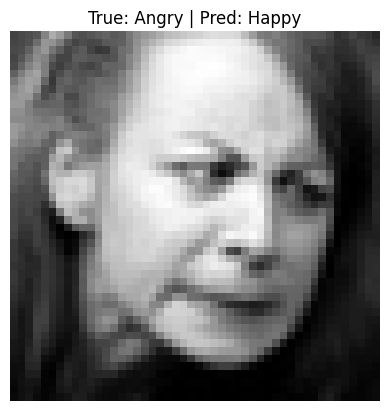

Original: angry → Predicted: happy



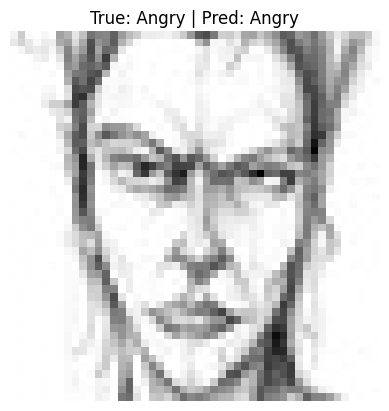

Original: angry → Predicted: angry



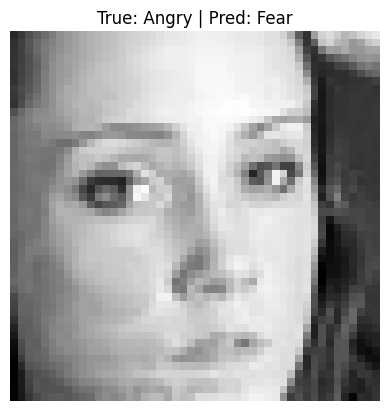

Original: angry → Predicted: fear



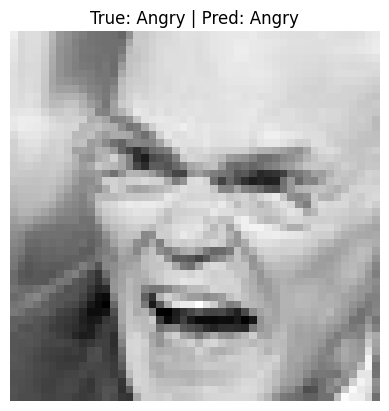

Original: angry → Predicted: angry



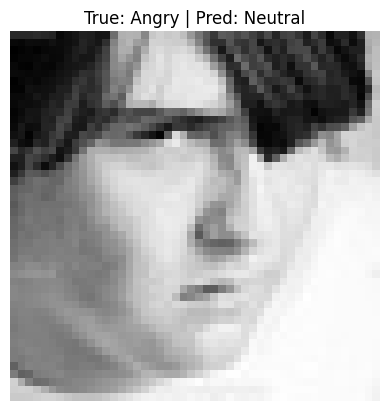

Original: angry → Predicted: neutral



In [10]:
def main() -> None:
    print(f"Using device: {DEVICE}\n")

   
    dl_tr_c, dl_te_c, dl_tr_f, dl_te_f = create_datasets()

   
    model_coarse = EmotionCNN(num_classes=len(COARSE_EMOTIONS)).to(DEVICE)
    model_fine   = EmotionCNN(num_classes=len(FINE_EMOTIONS)).to(DEVICE)

    
    criterion_c = nn.CrossEntropyLoss()
    optimizer_c = optim.Adam(model_coarse.parameters(), lr=LEARNING_RATE)
    criterion_f = nn.CrossEntropyLoss()
    optimizer_f = optim.Adam(model_fine.parameters(),   lr=LEARNING_RATE)

    
    print("▶️  Training coarse model (4 classes)…")
    train_model(
        model_coarse,
        dl_tr_c, dl_te_c,
        criterion_c, optimizer_c,
        NUM_EPOCHS
    )
    torch.save(model_coarse.state_dict(), "coarse_model.pth")
    print("✅  Saved coarse_model.pth\n")

   
    print("▶️  Training fine model (4 classes: only other)…")
    train_model(
        model_fine,
        dl_tr_f, dl_te_f,
        criterion_f, optimizer_f,
        NUM_EPOCHS
    )
    torch.save(model_fine.state_dict(), "fine_model.pth")
    print("✅  Saved fine_model.pth\n")

   
    model_coarse.load_state_dict(torch.load("coarse_model.pth", map_location=DEVICE))
    model_fine  .load_state_dict(torch.load("fine_model.pth", map_location=DEVICE))

    
    print("▶️  Sample hierarchical predictions:\n")
    test_paths, test_labels = create_dataframe(TEST_DIR)
    sample_idxs = [0, 10, 20, 30, 40]  
    for idx in sample_idxs:
        img_path = test_paths[idx]
        true_lbl = test_labels[idx]
        img = Image.open(img_path).convert('L')
        x   = transform(img).unsqueeze(0).to(DEVICE)

        
        model_coarse.eval()
        with torch.no_grad():
            out_c  = model_coarse(x)
            p_c    = torch.argmax(out_c, dim=1).item()
            lbl_c  = COARSE_EMOTIONS[p_c]

       
        if lbl_c != 'other':
            pred_lbl = lbl_c
        else:
            model_fine.eval()
            with torch.no_grad():
                out_f    = model_fine(x)
                p_f      = torch.argmax(out_f, dim=1).item()
                pred_lbl = FINE_EMOTIONS[p_f]

       
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_lbl.capitalize()} | Pred: {pred_lbl.capitalize()}")
        plt.axis('off')
        plt.show()
        print(f"Original: {true_lbl} → Predicted: {pred_lbl}\n")

if __name__ == "__main__":
    main()
